<img src="kntu-logo.png">

# Digital Image Processing
## First Computer Assignment
### Amirhosein Najafi (I)
### Student ID : 40112894
### Professor : Dr. Abrishami (II)

#### I : a.najafi@email.kntu.ac.ir
#### II : moghadam@eetd.kntu.ac.ir

## Part 1 -  2D Wavelet Denoising 

### Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pywt
import pywt.data
from scipy.signal import convolve2d

####  Reading  Images and Adding Noise to Image

In [2]:
def scale_images(image):
    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
    return normalized_image

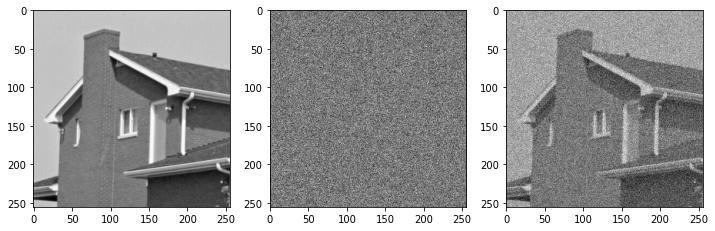

In [3]:
house = cv2.imread(r"house.png")
house = cv2.cvtColor(house, cv2.COLOR_BGR2GRAY)

row, col = house.shape

var = 10
mean = 0
sigma= np.sqrt(var)
gaussian = scale_images(np.random.normal(mean, sigma, (house.shape[0],house.shape[1]))) 

noised_house = scale_images(house + gaussian)

plt.figure(figsize=(12, 10))  # Set the desired width and height

plt.subplot(2,3,1)
plt.imshow(house, cmap='gray')
plt.subplot(2,3,2)
plt.imshow(gaussian, cmap='gray')
plt.subplot(2,3,3)
plt.imshow(noised_house, cmap='gray')

In [4]:
def psnr(original_image, compressed_image):
    mse = np.mean((original_image - compressed_image) ** 2)
    R = 255
    psnr = 10 * np.log10(R**2 / mse)

    return psnr

#### Calculation PSNR Score

In [5]:
print(psnr(house,noised_house))

19.767943714667197


In [29]:
wavelet = pywt.Wavelet('db4')
dec_lo, dec_hi = np.array(wavelet.dec_lo), np.array(wavelet.dec_hi)
rec_lo, rec_hi = np.array(wavelet.rec_lo) , np.array(wavelet.rec_hi)

In [30]:
def wt2d(x2d, LoD, HiD, nlevels = 1):
    coeffs = [x2d]

    row, col = x2d.shape
    
    result = np.zeros((row, col), dtype=float)

    for l in range(nlevels):
        
        # Row Convolution and Down Sampling
        row_high = convolve2d(coeffs[-1], HiD.reshape((1, HiD.shape[0])), mode='same')[:, 1::2]
        row_low = convolve2d(coeffs[-1], LoD.reshape((1, HiD.shape[0])), mode='same')[:, 1::2]
        
        # Column Convolution and Down Sampling
        column_high_high = convolve2d(row_high, HiD.reshape((LoD.shape[0],1)), mode='same')[1::2, :]
        column_high_low = convolve2d(row_high, LoD.reshape((LoD.shape[0],1)), mode='same')[1::2, :]
        column_low_high = convolve2d(row_low, HiD.reshape((LoD.shape[0],1)), mode='same')[1::2, :]
        column_low_low = convolve2d(row_low, LoD.reshape((LoD.shape[0],1)), mode='same')[1::2, :]
          
        coeffs[-1] = scale_images(column_high_high)
        coeffs.append(scale_images(column_high_low))
        coeffs.append(scale_images(column_low_high))
        coeffs.append(scale_images(column_low_low))
                
        row = int(row / 2)
        
        result[0:row , 0:row] = scale_images(column_low_low)
        result[row:2 * row , 0:row] = column_low_high
        result[0:row , row: 2 * row] = column_high_low
        result[row:2 * row , row:2 * row] = column_high_high
                
    return coeffs, result

In [31]:
def upsample(image,ax):
    num_rows, num_cols = image.shape
    if ax == "row":
        output_array = np.zeros((2 * num_rows, num_cols))
        output_array[::2, :] = image
    else:
        output_array = np.zeros((num_rows, 2 * num_cols))
        output_array[:, ::2] = image
    return output_array


In [32]:
def iwt2d(y2d, LoD, HiD, nlevels = 1):
    
    row, col = y2d.shape
    row = int(row / (2 ** nlevels))
    
    output_array_r = np.zeros((2 * row, col))
    output_array_c = np.zeros((row, 2 * col))
    
    current_coeffs = [None, None, None, None]
    
    for l in range(nlevels):
        
        # Get Current Coeffs
        current_coeffs[0] = y2d[0:row , 0:row]
        current_coeffs[1] = y2d[0:row , row: 2 * row]
        current_coeffs[2] = y2d[row:2 * row , 0:row]
        current_coeffs[3] = y2d[row:2 * row , row:2 * row]
        
        # Up Sampleing

        current_coeffs[0] = upsample(current_coeffs[0],"row")
        current_coeffs[1] = upsample(current_coeffs[1],"row")
        current_coeffs[2] = upsample(current_coeffs[2],"row")
        current_coeffs[3] = upsample(current_coeffs[3],"row")
                
        # Convoloution Columns
        column_high_high = convolve2d(current_coeffs[3], HiD.reshape((LoD.shape[0],1)), mode='same')
        column_high_low = convolve2d(current_coeffs[1], LoD.reshape((LoD.shape[0],1)), mode='same')
        column_low_high = convolve2d(current_coeffs[2], HiD.reshape((LoD.shape[0],1)), mode='same')
        column_low_low = convolve2d(current_coeffs[0], LoD.reshape((LoD.shape[0],1)), mode='same')
        
        # Summation
        row_high = column_high_high + column_high_low
        row_low = column_low_high + column_low_low
        
        # Up Sampleing
        row_high = upsample(row_high,"col")
        row_low = upsample(row_low,"col")
        
        # Convoloution Rows
        row_high = convolve2d(row_high, HiD.reshape((1,LoD.shape[0])), mode='same')
        row_low = convolve2d(row_low, LoD.reshape((1,LoD.shape[0])), mode='same')

        row = row * 2
        
        y2d[0:row, 0:row] = row_high + row_low
        
    return(y2d)
        
        
        

In [33]:
nlevel = 2
DWT, DecImg = wt2d(noised_house, dec_lo, dec_hi, nlevel)

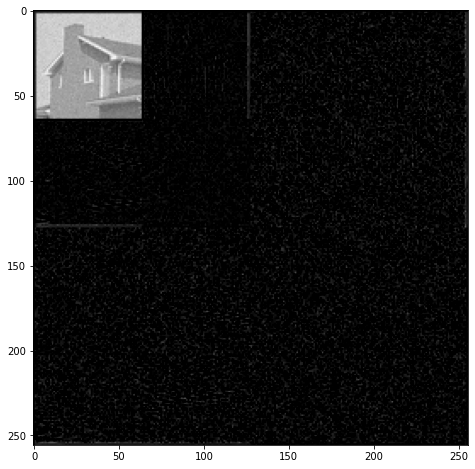

In [34]:
plt.figure(figsize=(10, 8))  # Set the desired width and height


plt.subplot(1,1,1)
plt.imshow(DecImg, cmap='gray', vmin=0, vmax=255)

In [35]:
def replacement(DWT, nlevel, DecImg):
    row, col = DecImg.shape

    l = 0
    cur = int(row / (2 ** (nlevel - l)))

    DecImg[0:cur , 0:cur] =  DWT.pop()

    while len(DWT) == 0:
        cur = int(row / (2 ** (nlevel - l)))

        DecImg[cur:2 * cur , 0:cur] =  scale_images(DWT.pop())
        DecImg[0:cur , cur: 2 * row] =  scale_images(DWT.pop())
        DecImg[cur:2 * cur , cur:2 * row] =  scale_images(DWT.pop())

        l += 1
        
    return DecImg
        
    
def wavelet_denoising(coeff, threshold_factor, nlevel, DecImg):
    
    threshold = threshold_factor * np.sqrt(2 * np.log(len(coeff)))
    denoised_coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeff]
    return replacement(denoised_coeffs, nlevel, DecImg)





In [36]:
DecImg = wavelet_denoising(DWT, 1, nlevel, DecImg)

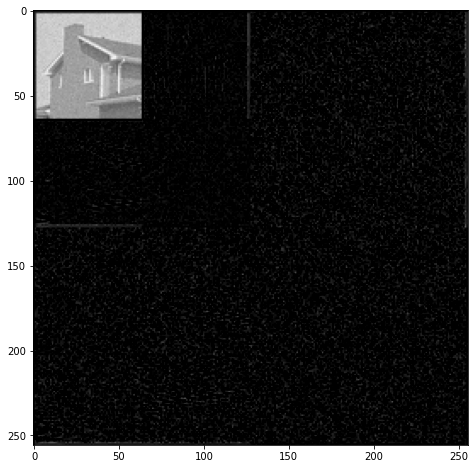

In [37]:
plt.figure(figsize=(10, 8))  # Set the desired width and height


plt.subplot(1,1,1)
plt.imshow(DecImg, cmap='gray', vmin=0, vmax=255)

In [38]:
RecImg = iwt2d(DecImg.copy(), rec_lo, rec_hi, nlevel)

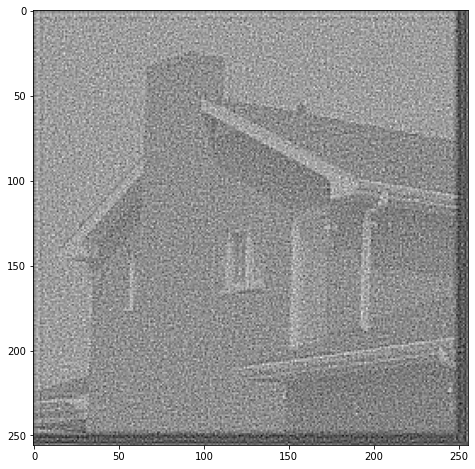

In [39]:
plt.figure(figsize=(10, 8))  # Set the desired width and height


plt.subplot(1,1,1)
plt.imshow(RecImg, cmap='gray')

In [40]:
print(psnr(house,RecImg))

7.563795179953162


In [41]:
DecLevel = [1, 2, 3]
var = [1, 10, 100]

import math 
ps = -math.inf
x, y = None, None

combinations = [(a, b) for a in DecLevel for b in var]

# Print the combinations
for d, v in combinations:
    DWT, DecImg = wt2d(noised_house, dec_lo, dec_hi, d)
    
    DecImg = wavelet_denoising(DWT, v, d, DecImg)
    
    RecImg = iwt2d(DecImg.copy(), rec_lo, rec_hi, d)  
    
    if psnr(house,RecImg)>ps:
        ps = psnr(house,RecImg)
        x, y = d, v
    
    print(f"PSNR with Decomposition level of {d} and Landa Value {v} is : {psnr(house,RecImg)}")
    

print("-" * 80)
print(f"The best is : Decomposition level of {x} and Landa Value {y}")
        
    

PSNR with Decomposition level of 1 and Landa Value 1 is : 11.372357853401354
PSNR with Decomposition level of 1 and Landa Value 10 is : 10.613264761285153
PSNR with Decomposition level of 1 and Landa Value 100 is : 5.313616040895548
PSNR with Decomposition level of 2 and Landa Value 1 is : 7.563795179953162
PSNR with Decomposition level of 2 and Landa Value 10 is : 7.2582118396931605
PSNR with Decomposition level of 2 and Landa Value 100 is : 4.897711557425878
PSNR with Decomposition level of 3 and Landa Value 1 is : 6.187356230717295
PSNR with Decomposition level of 3 and Landa Value 10 is : 6.0513848804429395
PSNR with Decomposition level of 3 and Landa Value 100 is : 4.89235873411031
--------------------------------------------------------------------------------
The best is : Decomposition level of 1 and Landa Value 1


In [42]:
DWT, DecImg = wt2d(noised_house, dec_lo, dec_hi, x)  
DecImg = wavelet_denoising(DWT, y, x, DecImg)
RecImg = iwt2d(DecImg.copy(), rec_lo, rec_hi, x) 

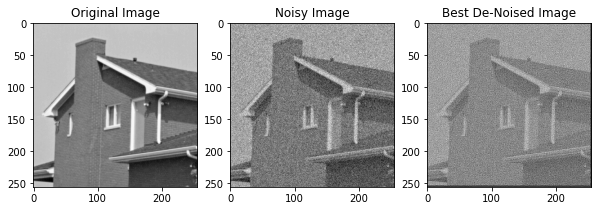

In [59]:
plt.figure(figsize=(10, 8))


plt.subplot(1,3,3)
plt.title("Best De-Noised Image")
plt.imshow(RecImg+60, cmap='gray',vmin=0, vmax=255)
plt.subplot(1,3,2)
plt.title("Noisy Image")
plt.imshow(noised_house, cmap='gray')
plt.subplot(1,3,1)
plt.title("Original Image")
plt.imshow(house, cmap='gray')